# **Data Analysis from UTA for the paper**

This Contains the analysis and code for generating the paper plots from UTA. It processes Pressure sweep data taken by Varghese and Alfredo in 11/2023. This code is designed to pull from a folder called "Data" which is also in this github, and contains both data sets. It also processes an E feild sweep at 633 Torr. This contains the following Analysis procedures:

## 1. Data Filtering and Processing
   
 - Discarding the first packet from the zybo (this was left over from the last run)
 - Converting from timestamps to RTDs
 - Discarding nonphysical RTDs
   
## 2. Calculating Charge Per Reset from calibration Data

 - Finding the mean RTD and 1 standard deviation
 - Plotting the input current vs 1/meanRTD, and propagating errors
 - Fitting a line to that data
 - Finding the slope of the line using a weighted polynomial regression fit
 - Getting the error on the slope fit
 - Generating a plot comparing Charge per reset vs Vdd value

## 3. Calculating Current
   
 - Removing outliers doing two rounds of z-score analysis, this gets rid of RTDs due to the stopping caused by integrator resetting to a negative rail
 - Finding the average RTD Value, and 1 standard deviation
 - Calculating the total Current seen per unit area based on the average RTD values. We calculate current rather than charge beacause pressure to pressure the amount of time the experiment was run was different, and we know we are missing resets from the IVC chip resetting to a negative rail occasionally, so We cant do total charge seen for a time period. I=q/t=ChargePerReset/avgRTD
 - Propagate errors on ChargePerReset and avgRTD
   
## 4. Finding Ring areas and Radius

 - Calculate area using same analysis as Wellseley
 - Calculating the area radius
 - Make the plot of I/mm vs R


In [341]:
import matplotlib.pyplot as plt
import ast
import numpy as np
import  os
from pathlib import Path
from scipy.stats import skewnorm
from scipy.optimize import curve_fit
from scipy.integrate import quad

## 1. Data Filtering and Processing:

In [378]:
# Specify if you want to process E feild data sweep data or presssure sweep data
#SweepType = 'Pressure'
SweepType = 'Feild'

In [379]:
"""input a text file containing a 2d list with 16 lists of rtds, parsed from
    the root file and converted to seconds. Specify if your data directory is in this directory or not"""
# Get the directory of the notebook
notebook_path = globals()['_dh'][0]
current_dir = str(Path(notebook_path).resolve())
dirList = []
filepaths_list = []


if SweepType == 'Pressure':
    subDir = 'PressureSweeps'
if SweepType == 'Feild':
    subDir = 'EFeildSweep633Torr'
    
dir=os.path.join(current_dir.split('Process')[0], 'Data/VargheseAlfredoPressureSweeps/' + subDir)
filepaths_list = [os.path.join(dir, file) for file in os.listdir(dir) if
                  file.endswith(".txt") and "V" in file]


In [380]:
#convert to RTDs from time stamps
errsAbove = []
errsBelow = []
data_dictionary = {}

eachFileRTDHolder=[]
# Go through each individual pressure run and do analysis
for filepath in filepaths_list:
    # Initialize a list to hold the 16 lists of reset time differences for data
    reset_time_diffs = [[] for _ in range(16)]

    # Read in the data from the text file and populate the list
    with open(filepath, "r") as f:
        # Read the contents of the file and use 'ast.literal_eval()' to safely parse it as a Python literal
        data = ast.literal_eval(f.read())

        # Iterate over the elements of 'data' using enumeration
        maxTimeStamp=0
        for i, timeStamps in enumerate(data):

            # Check if there are rtds, if not leave the list empty as it already is
            if len(timeStamps) > 0:
                rtd_list = []
                timeStamps= [timestamp * 200 / 30e6 for timestamp in timeStamps]
                if timeStamps[-1] > maxTimeStamp:
                    maxTimeStamp = timeStamps[-1]
                for index in range(0,len(timeStamps)):
                    if index !=0:
                        rtd = timeStamps[index]-timeStamps[index - 1]
                        rtd_list.append(rtd)
                reset_time_diffs[i] = [value for value in rtd_list]

            else:
                continue
    eachFileRTDHolder.append(reset_time_diffs)

## 2. Calculating Charge Per Reset from calibration Data:

In [381]:
# Get the directory of the notebook
notebook_path = globals()['_dh'][0]
current_dir = str(Path(notebook_path).resolve())

dirList=[]

dirList.append(os.path.join(current_dir.split('Process')[0],'Data/VargheseAlfredoCalibration/Calibration11142023'))
dirList.append(os.path.join(current_dir.split('Process')[0],'Data/VargheseAlfredoCalibration/Calibration11152023'))
dirList.append(os.path.join(current_dir.split('Process')[0],'Data/VargheseAlfredoCalibration/Calibration11162023'))

chargePerResetChPerCalibration=[]
rtdStdevsPerChPerCalibration=[]
chargePerResetStdevPerChPerCalibration=[]
for dir in dirList:
    calibration_filepaths_list = []

    calibration_filepaths_list = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith(".txt") and "nA" in file]
    # Sort the list of file paths alphabetically
    calibration_filepaths_list = sorted(calibration_filepaths_list)

    # Define the path to the text file
    filelist1 = []
    filelist2 = []
    filelist3 =[]
    filelist4 =[]

    for file in calibration_filepaths_list:
        if "0p01nA" in file:
            filelist1.append(file)
        if "0p07nA" in file:
            filelist2.append(file)
        if "0p1nA" in file:
            filelist3.append(file)
        if "0p5nA" in file:
            filelist4.append(file)
            
    #0.01,0.07,0.1,0.5nA
    filelists=[filelist1,filelist2,filelist3,filelist4]
    datalists=[]
    averageRtdLists=[]
    stdevs=[]
    n=0
    for filelist in filelists: #go through each current
        thisCurrentsData = [[] for _ in range(14)]  #for each current there are 14 channels
        thisCurrentAverages = [[] for _ in range(14)]
        thisCurrentstdevs = [[] for _ in range(14)]
        for thisfilepath in filelist: #go t0 each channel
            with open(thisfilepath, "r") as f:
                data = ast.literal_eval(f.read()) #get the data which has 16 channels but you only need 1
                chnum = int(thisfilepath.split("Ch")[1].split("_")[0])-1 #get the channel number

                times=[]
                for timeStamp in data[chnum]: #convert each one to new time
                    times.append(timeStamp * 200 / 30e6)
                rtd_list = []
                for index in range(9, len(times)): #skip the 0 packets in front
                    rtd = times[index] - times[index - 1]
                    rtd_list.append(rtd)
                if not rtd_list:
                    print("The list is empty.")
                thisCurrentAverages[chnum]=np.average(rtd_list)
                thisCurrentsData[chnum]=rtd_list
                thisCurrentstdevs[chnum] = np.std(rtd_list)
        datalists.append(thisCurrentsData)
        averageRtdLists.append(thisCurrentAverages)
        stdevs.append(thisCurrentstdevs)
        n+=1

    chargePerReset=[] #14 charges for each channel for this directory, each from slope of lin lits to 4 diff currents
    errsChargePerReset=[]
    for i in range(14):
        y = [0.01*(1e-9), 0.07*(1e-9), 0.1*(1e-9), 0.5*(1e-9)]
        x = [1 / averageRtdLists[0][i], 1 / averageRtdLists[1][i], 1 / averageRtdLists[2][i], 1 / averageRtdLists[3][i]]
        xerr=[   stdevs[0][i]/((averageRtdLists[0][i])**2),    stdevs[1][i]/((averageRtdLists[1][i])**2),      stdevs[2][i]/((averageRtdLists[2][i])**2) ,   stdevs[3][i]/((averageRtdLists[3][i])**2)]

        # Define the degree of the polynomial fit (1 for linear fit)
        degree = 1

        # Calculate the weights based on the inverse of the errors
        weights = [1 / err for err in xerr]
        
        # Perform the weighted polynomial fit using numpy.polyfit
        coefficients, cov_matrix = np.polyfit(x, y, degree, w=weights, cov=True)
        
        # Calculate slope error (chargePerReset error) from covariance matrix
        slope_error = np.sqrt(cov_matrix[1][1])  
    
        polynomial = np.poly1d(coefficients)
        line_of_best_fit = polynomial(x)

        chargePerReset.append(coefficients[0])
        errsChargePerReset.append(slope_error)

    chargePerResetChPerCalibration.append(chargePerReset)
    chargePerResetStdevPerChPerCalibration.append(errsChargePerReset)
    rtdStdevsPerChPerCalibration.append(stdevs)

In [ ]:
#plot the fits

for num in range(0, len(chargePerResetChPerCalibration)):
    dir=dirList[num]
    
    fig, axs = plt.subplots(3, 5, figsize=(15, 9))

    # Flatten the axs array for easy iteration
    axs = axs.flatten()
    
    for i in range(14):
        y = [0.01*(1e-9), 0.07*(1e-9), 0.1*(1e-9), 0.5*(1e-9)]
        x = [1 / averageRtdLists[0][i], 1 / averageRtdLists[1][i], 1 / averageRtdLists[2][i], 1 / averageRtdLists[3][i]]
        xerr=[rtdStdevsPerChPerCalibration[num][0][i]/((averageRtdLists[0][i])**2),  rtdStdevsPerChPerCalibration[num][1][i]/((averageRtdLists[1][i])**2),   rtdStdevsPerChPerCalibration[num][2][i]/((averageRtdLists[2][i])**2) , rtdStdevsPerChPerCalibration[num][3][i]/((averageRtdLists[3][i])**2)]

        # Define the degree of the polynomial fit (1 for linear fit)
        degree = 1

        # Calculate the weights based on the inverse of the errors
        weights = [1 / err for err in xerr]
        
        # Perform the weighted polynomial fit using numpy.polyfit
        coefficients, cov_matrix = np.polyfit(x, y, degree, w=weights, cov=True)
        slope_error = np.sqrt(cov_matrix[1][1])  
        
        polynomial = np.poly1d(coefficients)
        line_of_best_fit = polynomial(x)

        chargePerReset.append(coefficients[0])
        # Plot the data points

        '''
        axs[i].plot(x, y, '.', label=f'ChargePerReset: {coefficients[0]:.14f}')
        axs[i].plot(x, y, '.', label=f'ChargePerResetErr: {slope_error:.14f}')
        '''
        
        # Plot the line of best fit and data points and errorbars
        axs[i].plot(x, y, 'o', label='Data points')
        axs[i].errorbar(x, y, xerr=(xerr, xerr), fmt='none', capsize=6, markersize='6')
        axs[i].plot(x, line_of_best_fit, label=f'Line of best fit: {coefficients[0]:.2e}x + {coefficients[1]:.2e} ')

        # Create legend entries dynamically
        legend_entries = [
          'Data points',
          f'Line of best fit',
        ]
        
        # Get y axis limits for text placement
        ymin, ymax = axs[i].get_ylim()
        
        # Print ChargePerResetErr below the legend with spacing
        axs[i].text(
            0.5, ymin + 0.7 ,
            f'Charge Per Reset Err: {slope_error:.2e}',
            ha='center', va='top', fontsize='small', color='black', transform=axs[i].transAxes
        )
        axs[i].text(
            0.5, ymin + 0.8 ,
            f'Charge Per Reset: {coefficients[0]:.2e}',
            ha='center', va='top', fontsize='small', color='black', transform=axs[i].transAxes
        )
        
        # Add legend with all entries
        axs[i].legend(legend_entries, loc='upper left', fontsize='small')

        # Set labels and title for the subplot
        axs[i].set_xlabel('1/(Avg Rtd) (1/s)')
        axs[i].set_ylabel('Input I (A)')
        axs[i].set_title('Ch ' + str(i+1) + '  Analysis')

        # Show legend with smaller font size
        axs[i].legend(fontsize=6)

    # Adjust layout for better spacing
    fig.suptitle(str(dir.split('/')[-1]))

    fig.tight_layout()
    fig.savefig(os.path.join(current_dir.split('Process')[0],'Plots/VargheseAlfredoData/CalibrationFit/')+str(dir.split('/')[-1])+'.png', dpi=500)


In [ ]:
# Make charge per Reset vs RTD plot
for num in range(0, len(chargePerResetChPerCalibration)):

    plt.figure()

    #Feducialize at ch 12 can be justified because of the E feilds on 13/14, but in rewlity I remove them becaue the Vdd values are far off here
    
    ch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    QperReset = chargePerResetChPerCalibration[num][:14]
    err = chargePerResetStdevPerChPerCalibration[num][:14]
    
    plt.title('Charge Per Reset')
    plt.ylabel('Q/Reset (C/Reset)')
    plt.xlabel('Channel Number')
    plt.errorbar(ch,QperReset, yerr=(err, err),label='Charge/Reset')
    plt.legend(loc='upper left')
    plt.ylim(0, 1.2e-11)
    
    plt.twinx()
    
    # Plot the second dataset on the second y-axis
    vddch = [118,119,215,132,126,111,116,117,134,115,129,178,106,155]
    plt.scatter(ch, vddch, color='green', label='Vdd Value')
    plt.ylabel('Vdd (mV)')
    plt.legend(loc='upper right')
    plt.ylim(0, 250)
        
    # plt.errorbar(xnumRtds, y, yerr=yer, xerr=xer, fmt='o', markersize=2, linewidth=0.01, capsize=8, color='black', ecolor='red')
    plt.savefig(os.path.join(current_dir.split('Process')[0],'Plots/VargheseAlfredoData/ChargePerReset/') + 'CalibrationNumber' + str(num) + '.png', dpi=500)


## 3. Calculating Current:

In [ ]:
# Parse the pressure and feild from the headers
sweepNumValues=[]
for filepath in filepaths_list:
    if SweepType == 'Pressure':
        if "Hgbelowatm" in filepath:
            inHg = filepath.split('inHgbelowatm')[0].split('100Hz_')[1]
            inHg = 29.9213 - float(inHg)  # below 1 atm (1atm=29.9213 inHg)
            sweepNum = inHg / 2.036  # (in psi)
            sweepNumValues.append(sweepNum)
        
        elif "psi" in filepath:
            RelativePsi = filepath.split('psi')[0].split('100Hz_')[1]
            sweepNum = 14.6959 + float(RelativePsi)
            sweepNumValues.append(sweepNum)
        else:
            print("error in parsing file headers")
            print(filepath)
            
    if SweepType == 'Feild':
        if "kV_" in filepath:
            sweepNum = str(int(filepath.split('kV_')[0].split('/')[-1])*1000)
            sweepNumValues.append(sweepNum)
        elif "V" in filepath:
            sweepNum = str(filepath.split('V_')[0].split('/')[-1])
            sweepNumValues.append(sweepNum)
        else:
            print("error in parsing file headers")
            print(filepath)

In [ ]:
meanRtdPerCh=[0]*(len(reset_time_diffs))

In [ ]:
#plot RTDs before removing outliers (move this below the next code block if you want to plot after removing outliers)
num = 0
for fileRTDs in eachFileRTDHolder:
    sweepNum = sweepNumValues[num]
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    axs = axs.ravel()
    if SweepType == 'Pressure':
        fig.suptitle('Pressure: '+ str(round(float(sweepNum) * 51.715, 1)) + ' Torr at 500v/cm', fontsize=16)
    if SweepType == 'Feild':
        fig.suptitle('Feild: '+ str(sweepNum) + ' V at 633 Torr', fontsize=16)
    
    for i in range(0, len(fileRTDs)):
    
        # Need to make this greater than one reset because otherwise there is a division by 0 error
        if len(fileRTDs[i]) > 1:
            
            # Get the mean
            meanRtd = np.mean(fileRTDs[i])
            meanRtdPerCh[i] = meanRtd
    
            # Uncomment to take a look at your rtds for each individual channel on a different plot per pressure
    
            axs[i].hist(fileRTDs[i], bins=50) # loook into this function for bins
            axs[i].axvline(meanRtd, color='blue', linestyle='--', label='meanRTD')
            axs[i].set_xlabel("rtd (s)")
            axs[i].set_ylabel("Frequency")
       
            axs[i].set_title("Ch{}".format(i + 1))
            axs[i].legend(fontsize=6)
    
    fig.tight_layout()        
    if SweepType == 'Pressure':
        fig.savefig(os.path.join(current_dir.split('Process')[0],'Plots/VargheseAlfredoData/rtdSpread/PressureSweeps/')+str(round(float(sweepNum) * 51.715, 1))+'.png')
    if SweepType == 'Feild':
        fig.savefig(os.path.join(current_dir.split('Process')[0],'Plots/VargheseAlfredoData/rtdSpread/EFeildSweeps/')+str(sweepNum)+'.png')
    
    num+=1



In [ ]:
#Remove outliers
def zscoreAnalysis(data):
    mean = np.mean(data)
    std = np.std(data)
    data_zscore = [abs((point - mean)/std) for point in data]
    return data_zscore
    
eachFileRTDHolderOutlierRemoved = []
meanRtdPerCh=[0]*(len(reset_time_diffs))
for fileRTDs in eachFileRTDHolder:
    thisPressureRtds=[]
    for i in range(0, len(fileRTDs)):
        #get z scores if not empty
        if fileRTDs[i]:
            data_zscores = zscoreAnalysis(fileRTDs[i])
    
            #filter based on 2 sigma
            chRTDs = [x for x, y in zip(fileRTDs[i], data_zscores) if (y < 2)]
            filteredzscores= [y for x, y in zip(chRTDs, data_zscores) if (y < 2)]
    
            #iterate twice
            data_zscores = zscoreAnalysis(chRTDs)
            chRTDs = [x for x, y in zip(chRTDs, data_zscores) if (y < 2)]
            
            thisPressureRtds.append(chRTDs)
    
            # Get the new mean
            meanRtd = np.mean(chRTDs)
            meanRtdPerCh[i] = meanRtd
        else:
            thisPressureRtds.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    eachFileRTDHolderOutlierRemoved.append(thisPressureRtds)

In [ ]:
#Get the average Current and Errors
errs=[]
fileNum=0
data_dictionary = {}
for filepath in filepaths_list:
    sweepNum = sweepNumValues[fileNum]
    
    Q_perReset_perChannel = chargePerResetChPerCalibration[2] #grab that list of 14 charge values, just use the last calibration run
    sigmaQ_perReset_perChannel = chargePerResetStdevPerChPerCalibration[2] #grab that list of 14 charge uncertainty values, just use the last calibration run
    
    AvgI_PerChannel = []
    errorsPerPressure = []
    
    # Only do this for the fiducial volume
    for i in range(0, 14):

        #number of resets * deltaChargePerReset = total charge seen on that channel
        if np.average(eachFileRTDHolderOutlierRemoved[fileNum][i]) ==0:
            AvgI_PerChannel.append(0)
        else:
            avgI = Q_perReset_perChannel[i]/np.average(eachFileRTDHolderOutlierRemoved[fileNum][i]) 
            AvgI_PerChannel.append(avgI)

        # -------------------- Make your errors here ----------------------
        if len(eachFileRTDHolderOutlierRemoved[fileNum][i]) == 0:
            errorsPerPressure.append(0)
        else:
            #if not empty
            if eachFileRTDHolderOutlierRemoved[fileNum][i]:
                '''
                Find your error on total Q seen:
                I = Q/t = chargePerReset/avgRtd
                 
                Now propagate the errors on average rtds(R) and Charge Per reset(Q) fromt the calibration fit:
                SigmaI = I * sqrt(((sigmaQ/Q)^2+(sigmaR/R)^2)

                '''
                
                SigmaI =avgI * np.sqrt(((sigmaQ_perReset_perChannel[i]/Q_perReset_perChannel[i])**2) + ((np.std(eachFileRTDHolderOutlierRemoved[fileNum][i])/np.average(eachFileRTDHolderOutlierRemoved[fileNum][i]))**2))

                # print('QPerReset: ' + str(Q_perReset_perChannel[i]))
                # print('QPerResetErr: ' + str(sigmaQ_perReset_perChannel[i]))
                
                # print('avgRtd: ' + str(np.average(eachFileRTDHolder[fileNum][i])))
                # print('avgRtdErr: ' + str(np.std(eachFileRTDHolder[fileNum][i])))
                
                # the sigma on rtd is making error bars so large. Tested by only propigating rtd error, error bars were large here
                # SigmaI = (Q_perReset_perChannel[i]/(np.std(eachFileRTDHolder[fileNum][i])**2))*np.std(eachFileRTDHolder[fileNum][i])
            
                '''
                Previously we added two resets due to the following reasons: 
                1. Add the the one quanta error, but only to the top (You can miss extra reset if you stop in middle)
                2. Add another quanta for when you make the rtd list if there is an odd number

                Here we are not counting resets, just avg current, so skip this
                '''
                errorsPerPressure.append(SigmaI)
    
    # For each pressure add your 16 channel list of errors
    errs.append(errorsPerPressure)

    # Add the data for this pressure/field to your dictionary with a key
    data_dictionary[sweepNum] = AvgI_PerChannel
    fileNum += 1

## 4. Finding Ring areas and Radius:

In [ ]:
#Calculate the radius (ring_avgs) and Area of Rings (ring_areas)

# Wellseley areas, the start and stop of each channel where edges are between concentric rings
minmax = [[0.000, 0.670], [0.670, 1.386], [1.386, 2.106], [2.106, 2.981],
          [2.981, 4.005], [4.005, 4.994], [4.994, 6.015], [6.015, 7.481],
          [7.481, 9.994], [9.994, 12.497], [12.497, 15.023], [15.023, 19.996],
          [19.996, 24.962], [24.962, 30.026], [30.026, 39.977], [39.977, 50.065]]


ring_avgs = [round((2/3)*(((end**3)-(start**3))/((end**2)-(start**2))), 3) for start, end in minmax]

# Area based on outer radius - Area based on inner radius for each channel
# Previously we had errors on the area based on the 0.001mm in measuring tool in gerber files, but later decided this was insignifigant 
ring_areas = [round(np.pi * ((end ** 2) - (start ** 2)), 3) for start, end in minmax]

#fiducialize everything
ring_avgs = ring_avgs[:14]
ring_areas = ring_areas[:14]



In [ ]:
#Plot your Current/mm vs Radius plot and save area normalized values

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gold', 'lime', 'pink', 'silver', 'gray', 'maroon', 'olive', 'teal',
              'navy']

# Define a base list of channel numbers (Fiducialized to 14 based on feild cage)
ch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

fig, ax = plt.subplots()
n = 0
AreaNormalizedAvgI_perCh = {}
AreaNormalizederrPerCh = {}
for key, value in data_dictionary.items(): #go to each pressure and get the 14ch Data
    AvgI_perCh = value
    errPerCh = errs[n]

    # Get average Current per mm^2 for current and errors(I dont think I need to propagate anything here b/c Im multiplying by constant)
    AvgI_perMM = [I / a for I, a in zip(AvgI_perCh, ring_areas)]
    AvgI_perMM = [0 if x is None or np.isnan(x) else x for x in AvgI_perMM]
    errPerCh_perMM = [Ierr / a for Ierr, a in zip(errPerCh, ring_areas)]
    errPerCh_perMM = [0 if x is None or np.isnan(x) else x for x in errPerCh_perMM]
    
    # Get the pressure or feild value from the key
    if SweepType == 'Pressure':
        sweepNum = round(float(key) * 51.715, 1)
        formatted_sweepNum = f'{sweepNum:06.1f}'
        ax.scatter(ring_avgs, AvgI_perMM, marker='.', label=str(formatted_sweepNum) + " Torr", color=colors[n])
    if SweepType == 'Feild':
        sweepNum = key
        formatted_sweepNum = f'{int(sweepNum):5.0f}'
        ax.scatter(ring_avgs, AvgI_perMM, marker='.', label=str(formatted_sweepNum) + " V", color=colors[n])
    
    # Save area normalized versions for future use
    AreaNormalizedAvgI_perCh[formatted_sweepNum] = AvgI_perMM
    AreaNormalizederrPerCh[formatted_sweepNum] = errPerCh_perMM
    
    ax.errorbar(ring_avgs, AvgI_perMM, yerr=(errPerCh_perMM,errPerCh_perMM), fmt='none', capsize=6, markersize='6', color=colors[n])
    ax.set_ylabel('Average Current (A) per mm\u00b2')

    y=AvgI_perMM
    x=ring_avgs
    n += 1

handles, labels = ax.get_legend_handles_labels()

# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels)

ax.set_xlabel('Radius (mm)')
ax.set_title('Current Distribution Across Radius')

if SweepType == 'Pressure':
    fig.savefig(os.path.join(current_dir.split('Process')[0],'Plots/VargheseAlfredoData/')+'PressureSweepIPerUnitAreavsRadius.png')
    with open(os.path.join(current_dir.split('Process')[0],'Plots/VargheseAlfredoData/')+'PressureSweepData.txt', "w") as f:
        f.write(f"Current List:\n") 
        f.write(f"{AreaNormalizedAvgI_perCh}\n")
        f.write(f"\n")
        f.write(f"Errors list:\n") 
        f.write(f"{AreaNormalizederrPerCh}\n")
        f.write(f"\n")
        f.write(f"Ring Centers:\n")
        f.write(f"{ring_avgs}\n")
if SweepType == 'Feild':
    fig.savefig(os.path.join(current_dir.split('Process')[0],'Plots/VargheseAlfredoData/')+'EFeildSweepIPerUnitAreavsRadius.png')
    with open(os.path.join(current_dir.split('Process')[0],'Plots/VargheseAlfredoData/')+'EFeildSweepData.txt', "w") as f:
        f.write(f"Current List:\n") 
        f.write(f"{AreaNormalizedAvgI_perCh}\n")
        f.write(f"\n")
        f.write(f"Errors list:\n") 
        f.write(f"{AreaNormalizederrPerCh}\n")
        f.write(f"\n")
        f.write(f"Ring Centers:\n")
        f.write(f"{ring_avgs}\n")



## 5. Calculating sigma

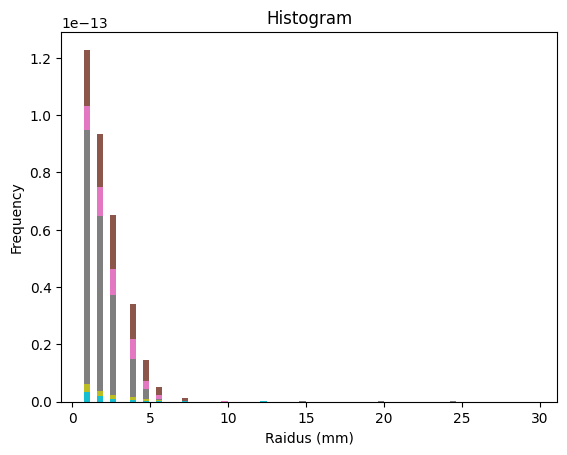

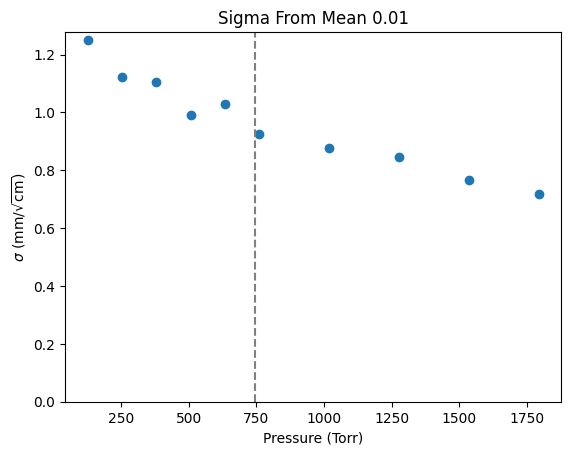

In [355]:
# Old Way of finding sigma from histogram 
# Made bins small enough to have 1 bin per channel. 
# An increase in bin size afer 70 doesnt change sigma at all for this reason (even 700 bin shows no change)))

def calculate_standard_deviations_mean(mm, plotting_sets, meanVal= 'DataSet'):

    standardDevs = []

    for i in range(0, len(plotting_sets)):
        # Convert the current per channel data for the current pressure to a NumPy array
        ydata_norm = np.array(plotting_sets[i])

        # Define the number of bins for the histogram to get sigma from
        bins = 70

        # Calculate the histogram with specified bins and use 'ydata_norm' as weights
        counts, bin_edges = np.histogram(mm, bins=bins, weights=ydata_norm)

        #visualize the histogram
        # Create and display the plot
        plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0])
        plt.xlabel("Raidus (mm)")
        plt.ylabel("Frequency")
        plt.title("Histogram")
        #plt.show()

        # Filter out bins with zero counts
        non_zero_bins = counts > 0

        # Calculate the bin centers for non-zero bins
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_centers = bin_centers[non_zero_bins]

        # Calculate the weighted sum of bin_centers multiplied by counts
        weighted_sum = np.sum(bin_centers * counts[non_zero_bins])

        # Calculate the total sum of counts
        total_count = np.sum(counts)

        # define the mean
        if meanVal == 'DataSet':
            mean = weighted_sum / total_count
            print("Mean of histogrammed data: ", mean)

        else:
            mean = meanVal
            #print("Set Mean: ", mean)

        # The following lines find the standard deviation from the histogram
        # Can find this information here: https://www.statology.org/histogram-standard-deviation/

        # Calculate the squared difference between each bin center and the mean
        centerminusmean = ((bin_centers - mean) ** 2)

        # Multiply each squared difference by the corresponding counts for non-zero bins
        countstimesdiff = counts[non_zero_bins] * centerminusmean

        # Calculate the I per press by summing the counts for non-zero bins
        totCurrPerPress = sum_list_values(counts[non_zero_bins])

        # Define nMinus1 as the total current per press
        nMinus1 = totCurrPerPress 

        # Calculate the numerator by summing the products of counts times squared differences
        numerator = sum_list_values(countstimesdiff)

        # Calculate the standard deviation of 'mm' using the formula for a sample
        std_mm = np.sqrt(numerator / nMinus1)

        # Append the standard deviation for this pressure to your total standard deviations
        standardDevs.append(std_mm)

    # Return components for error propagation, like the total Q across all channels seen per pressure, numerator, mean
    return totCurrPerPress, standardDevs,mean, numerator

def sum_list_values(lst):
    total = 0
    for value in lst:
        total += value
    return total


# Initialize variables
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'lime', 'pink', 'silver', 'gray', 'maroon', 'olive', 'teal', 'navy']
standardDevs = []
pressures = []
plotting_sets = []
i = 0

mm = [0.54, 1.3, 2, 2.8, 3.9, 4.9, 5.9, 7.4, 9.9, 12.4, 14.9, 19.9, 24.85, 29.9, 39.8, 49.9]
mm = mm[:14]

def plot_sigma(pressures, standardDevs,  numerator, totChargePerPress, meanFrom= 'DataSet'):

    # Divide by sqrt of drift length to get the standardized units
    standardDevs = [x/np.sqrt(10) for x in standardDevs] #10 cm 
    plt.figure()
    plt.scatter(pressures, standardDevs, label='500 & 50 V/cm')
    plt.axvline(x=745, color='grey', linestyle='--')
    
    plt.xlabel('Pressure (Torr)')
    plt.ylabel('$\sigma$ (mm/$\sqrt{\mathrm{cm}}$)')
    plt.ylim(bottom=0)
    
    plt.title('Sigma From Mean ' + str(meanFrom))
    


# Get the charge values for each pressure into a list
for key, value in data_dictionary.items():
    plotting_data = None

    pressure = key
    pressure = round(float(pressure) * 51.715, 1)
    pressures.append(pressure)

    plotting_data = [I / a for I, a in zip(value, ring_areas)]
    plotting_sets.append(plotting_data)
    i += 1

    # From the definiton call, grab the specified spot center
    mean = 0.01
    
# Calculate the standard deviations
totChargePerPress, standardDevs, mean, numerator = calculate_standard_deviations_mean(mm, plotting_sets, meanVal = mean)
plot_sigma(pressures, standardDevs,  numerator, totChargePerPress, meanFrom = mean)
    


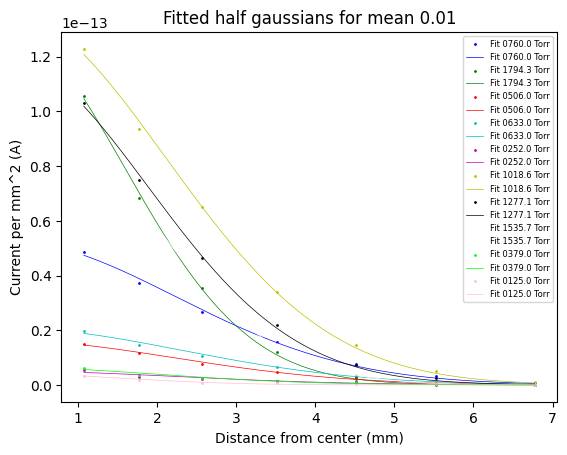

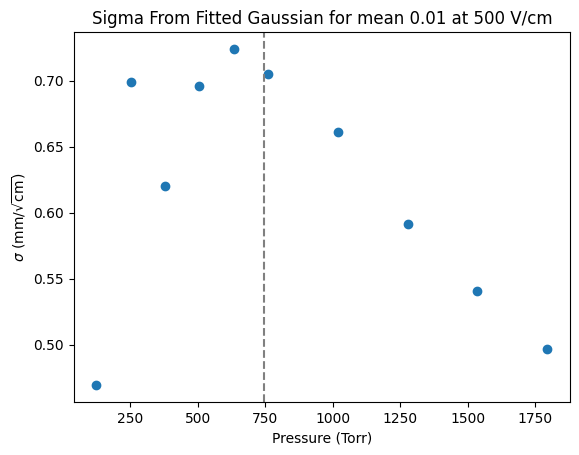

In [356]:
# New way trying to fit to data
def get_fitting_data(mean, mm, plotting_data):
    if mean > mm[1]:
        fittingmm = mm[2:]
        fittingdata = plotting_data[2:]
    elif mean < mm[1] and mean > mm[0]:
        fittingmm = mm[1:]
        fittingdata = plotting_data[1:]
    else:
        fittingmm = mm
        fittingdata = plotting_data
    return fittingmm, fittingdata
    
def fit_gaussian(half_gaussian, fittingmm, fittingdata):
    amplitude_guess = 1.0
    sigma_guess = 0.5
    initial_guess = [amplitude_guess, sigma_guess]
    popt, pcov = curve_fit(half_gaussian, fittingmm, fittingdata, p0=initial_guess)
    return popt, pcov
    
def half_gaussian(x, amplitude, sigma, m=0.01):
    return amplitude * np.exp(-(x - m) ** 2 / (2 * sigma ** 2)) * (x >= m)
    
sigmasFitted=[]    
ring_areas2 = ring_areas[1:8]
ring_avgs2 =ring_avgs[1:8]
vals=[]
i=0
for key, value in data_dictionary.items():
    value =[0 if x is None or np.isnan(x) else x for x in value] #some of these values are nan, redefine them
    value = value[1:8]

    plotting_data = [I / a for I, a in zip(value, ring_areas2)]
    key = str(key)


    pressure = key
    mean = 0.01
    fittingmm, fittingdata = get_fitting_data(mean, ring_avgs2, plotting_data)

    popt, pcov = fit_gaussian(half_gaussian, fittingmm, fittingdata)

    fitted_amplitude, fitted_sigma = popt
    sigmasFitted.append(fitted_sigma)

    gaussMM = np.linspace(fittingmm[0], fittingmm[-1], 1000)
    fitted_curve = half_gaussian(gaussMM, fitted_amplitude, fitted_sigma, m=mean)

    area, error = quad(lambda x: half_gaussian(x, *popt,mean), -np.inf, np.inf)
    plotting_data2 = np.array(fittingdata)

    if SweepType == 'Pressure':
        sweepNum = round(float(key) * 51.715, 1)
        formatted_sweepNum = f'{sweepNum:06.1f}'
        plt.scatter(ring_avgs2, plotting_data, s=1,color=colors[i], label='Fit ' + str(formatted_sweepNum) + ' Torr')
        plt.plot(gaussMM, fitted_curve, color=colors[i], linewidth=0.5, label='Fit ' + str(formatted_sweepNum) + ' Torr')
    if SweepType == 'Feild':
        sweepNum = key
        formatted_sweepNum = f'{int(sweepNum):5.0f}'
        plt.scatter(ring_avgs2, plotting_data, s=1,color=colors[i], label='Fit ' + str(formatted_sweepNum) + ' V')
        plt.plot(gaussMM, fitted_curve, color=colors[i], linewidth=0.5, label='Fit ' + str(formatted_sweepNum) + ' V')
    
    vals.append(sweepNum)

    plt.title('Fitted half gaussians for mean ' + str(mean))
    plt.xlabel('Distance from center (mm)')
    plt.ylabel('Current per mm^2 (A)')
    plt.legend(fontsize=6)

    i += 1
    
#plot sigmas
# Divide by sqrt of drift length to get the standardized units
sigmasFitted = [x/np.sqrt(10) for x in sigmasFitted] #10cm drift length
 
plt.figure()
plt.scatter(vals, sigmasFitted, label='500 V/cm')
plt.ylabel('$\sigma$ (mm/$\sqrt{\mathrm{cm}}$)')
if SweepType == 'Pressure':
    plt.axvline(x=745, color='grey', linestyle='--', label = '1 atm')
    plt.xlabel('Pressure (Torr)')
    plt.title('Sigma From Fitted Gaussian for mean ' + str(mean) + ' at 500 V/cm')
if SweepType == 'Feild':
    plt.xlabel('Feild (V)')
    plt.title('Sigma From Fitted Gaussian for mean ' + str(mean) + ' at 633 Torr')




In [298]:
#ask varghese how he did the radius calculation (slack hid that for me)